In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime

# IMAGE IMPORTS
from PIL import Image, TiffImagePlugin
import cv2

# GIS IMPORTS
from affine import Affine
import pandas as pd

# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


IO directories depending on which machine. 

In [2]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {"legacy" : True}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\Uncompress\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

Create working dir and unzip all files if needed

In [3]:
# MAKE PROCESSING DIRECTORY
datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
proc_dir     = os.path.join(base_output_path, datetime_str)

# IF THERE ARE ANY ZIP FILES IN DIRECTORY, UNZIP THEM IN PLACE
if len(glob.glob(base_input_path + "*.zip*")) != 0:
    extractZipFiles(base_input_path, base_input_path)

outputs_dir  = os.path.join(proc_dir, "Outputs")
os.makedirs(outputs_dir)

Read through all the images in the directory. Some images are saved as Multi-page TIFF files. These need to be exported into individual images. We'll do that first in-place at uncompressed directory

In [4]:
remove_files = []

for filename in tqdm(glob.glob(base_input_path + "\\*.tif*")):
    tiff_file = os.path.join(base_input_path, filename)
    try:
    # Check if the file is a multi-page TIFF
        with Image.open(tiff_file) as img:
            if img.is_animated:    
                print(f"Expanding {os.path.basename(tiff_file)} into {img.n_frames}")
                for i in range(img.n_frames):
                    try:
                        img.seek(i)
                        output_filename = f"{os.path.splitext(tiff_file)[0]}_{i+1}{os.path.splitext(tiff_file)[1]}"
                        img.save(output_filename, format=img.format)
                    except:
                        print(f"Error with {tiff_file} page {i}")
                        continue
                remove_files.append(tiff_file)
    except Exception as e:
        print(f"Error opening {tiff_file}")
        print(e)
        continue

for tiff_file in remove_files:
    os.remove(tiff_file)

  0%|          | 0/1704 [00:00<?, ?it/s]

Error opening D:\RECTDNN\Uncompress\485479B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485479B.tif'
Error opening D:\RECTDNN\Uncompress\485479C.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485479C.tif'
Error opening D:\RECTDNN\Uncompress\485481A.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485481A.tif'
Error opening D:\RECTDNN\Uncompress\485510.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485510.tif'
Error opening D:\RECTDNN\Uncompress\485510B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485510B.tif'
Error opening D:\RECTDNN\Uncompress\485514B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485514B.tif'
Error opening D:\RECTDNN\Uncompress\485516A.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485516A.tif'


Here we're using heuristics to identify indices within all the image files. These include:
- Files that are shorter than 12 characters
- Files that have the ```IND``` marker

We create a Pandas DataFrame with the files matching. We then add several fields as below

In [5]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{base_input_path}/*48201*")

# FILTER IMAGES USING HEURISTICS
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*48201*" + pattern + "*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# CREATE DATAFRAME
index_files = pd.DataFrame(index_files, columns=["FilePath"])

# INDEX ATTRIBUTES TO BE ADDED
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]    # BASENAME
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)   # 
index_files["GEOID"]    = index_files["Location"].apply(getGEOID)       # GET GEOID FOR EACH INDEX
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)       # GET GEOMETRY FROM MATCHING GEOIDs

  0%|          | 0/10 [00:00<?, ?it/s]

ICP Steps:   0%|          | 0/30 [00:00<?, ?it/s]

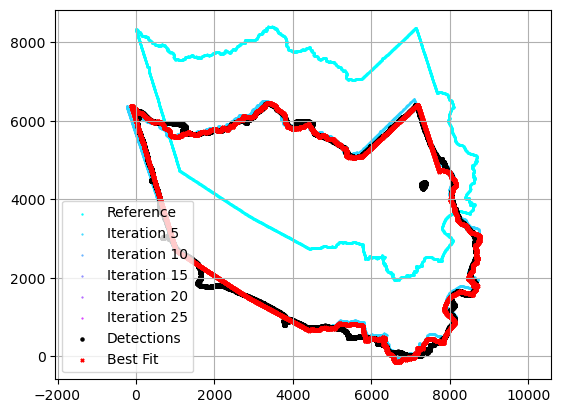

NameError: name 'tiles' is not defined

In [6]:
verbose = True

TPNN = None
RLNN = None
CLNN = None

try:
    gen_dict
    print("Starting with predefined dict")
except:
    gen_dict = {}

for i, row in tqdm(index_files.iterrows(), total=index_files.shape[0]):
    
        filename = os.path.basename(row["FilePath"])
        
        if os.path.exists(os.path.join(outputs_dir, f"{filename}.pkl")):
             print(f"Skipping, found {os.path.join(outputs_dir, filename + '.pkl')}")
             continue

        # READ FILES AND CONVERT TO GRAYSCALE
        image = cv2.imread(row["FilePath"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_arry = np.asarray(image)
        
        # SAVE IMAGE TO OUTPUT DIRECTORY
        output_image_fn = os.path.join(outputs_dir, filename.split(".")[0] + ".tif")
        copyfile(row["FilePath"], output_image_fn)

        # GET BOUNDARY POINTS FROM RESPECTIVE SHAPEFILE
        output = getBoundaryPoints(row, distance=100)
        if output is None:
            print(f"COULD NOT FIND SHAPEFILE FOR {filename}")
            continue
        point_boundary_gdf, shp_bounds = output
        
        # RUN IMAGES THROUGH DNNs
        classifications, TPNN  = findKeypoints(image, model=TPNN, **dnn_params['TPNN'])
        effectiveArea, RLNN    = findSquares(image, model=RLNN, **dnn_params['RLNN'])
        countyArea, CLNN       = findCounty(image, model=CLNN, **dnn_params['CLNN'])
        # tiles, TLNN            = findTiles(row["FilePath"], model=TLNN, **dnn_params['TLNN'], verbose=False, device="cuda",
        #                                    save_dir=os.path.join(outputs_dir, filename.split(".")[0] + "_BBNN.tif"))

        # tiles, TLNN = runTLNN(row['FilePath'])

        dnn_outputs = {
            "classifications"   : classifications,
            "effectiveArea"     : effectiveArea,
            "countyArea"    : countyArea,
            # "tiles"         : tiles
        }
        
        # GET COUNTY BOUNDS IDENTIFIED IN INDEX BY TLNN
        # bounds_panels = tiles["county"]["bbox"]
        bounds_panels = find_bbox(dnn_outputs['countyArea'][:, :, 1])

        # SKIP IF WE CAN'T FIND BOUNDARY IN EXISTING DATABASES
        if point_boundary_gdf is None:
            continue

        # DEFINE BOUNDARY STRUCTU
        boundaries = {
            "point_boundary_gdf"    : point_boundary_gdf,
            "shp_bounds"            : shp_bounds,
            "bounds_panels"         : bounds_panels,
        }

        # WHAT ARE WE LOOKING FOR IN EACH IDENTIFIED SQUARE?
        key = findKey(row["Basename"])    
        if key is None:
            print(f"Could not find key in {filename}")
        
        # DO ICP
        transform_dict = performICPonIndex(boundaries, dnn_outputs, debug=False, plot=True, rotation=True, shear=False, perspective=False, icp_iterations=30)

        # GET TRANSFORM FROM ICP TO CRS TRANSFORM
        output_transform, transform_dict = ICPtoCRSTransform(image_arry, transform_dict)

        # GET OUTPUT TRANSFORM INTO AFFINE AND WRITE
        output_affine = Affine(*output_transform.flatten()[:6])
        with rio.open(output_image_fn, 'w',
            driver='GTiff',
            height=image.shape[0], width=image.shape[1],
            count=1, dtype=image.dtype,
            crs=f'EPSG:3857',
            transform=rio.Affine(*output_transform.flatten()[:6])) as dst:
                dst.write(image, 1)   

        tiles['transform_info'] = transform_dict
        tiles['output_transform'] = output_transform
        gen_dict[filename] = tiles

        with open(os.path.join(outputs_dir, f"{filename}.pkl"), 'wb') as handle:
            pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open(os.path.join(outputs_dir, "IndexCoords.pkl"), 'wb') as handle:
    pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

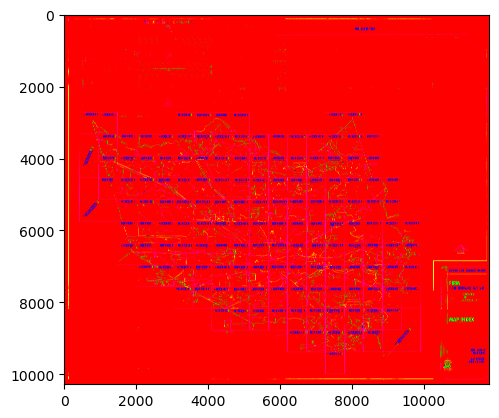

In [ ]:
plt.imshow(probability_to_rgb(dnn_outputs['classifications']))

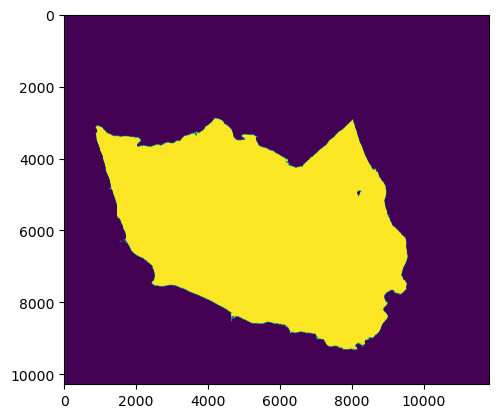

In [ ]:
plt.imshow(dnn_outputs["countyArea"][:, :, 1])

In [8]:
thin_image = getCountyBoundaryFromImage(dnn_outputs["countyArea"])

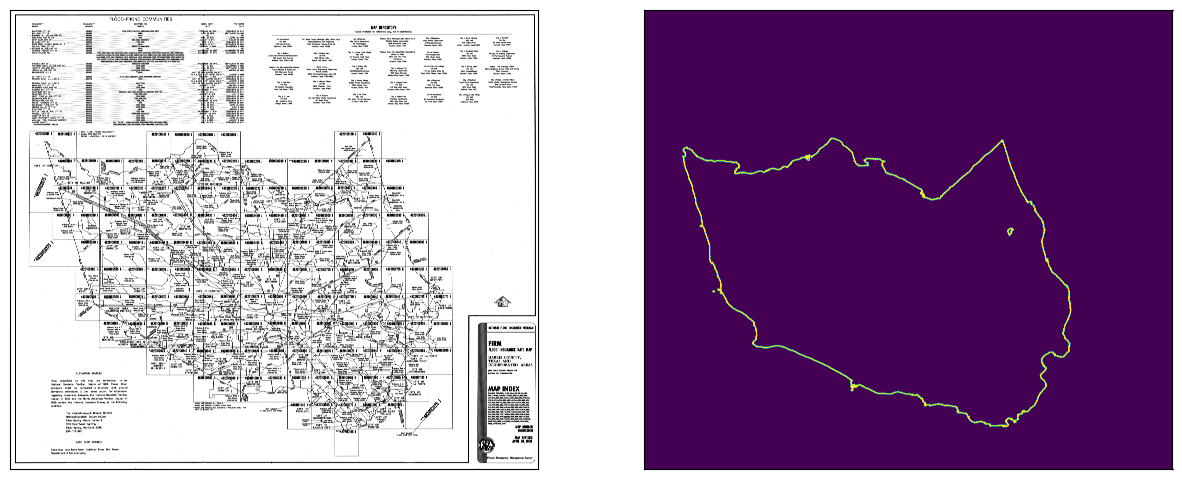

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 12))
axs[0].imshow(cv2.erode(image, kernel=np.ones((5,5))), cmap="Greys_r")
# axs[1].imshow(dnn_outputs["countyArea"][:, :, 1])
axs[1].imshow(cv2.dilate(thin_image, kernel=np.ones((25,25))))

# axs[0].set_title('Example Tile Index')
# axs[1].set_title('County Boundary Detected by Convolutional DNN')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
myout = probability_to_rgb(prob_img)

In [ ]:
%notebook autoreload

ICP Steps:   0%|          | 0/5 [00:00<?, ?it/s]

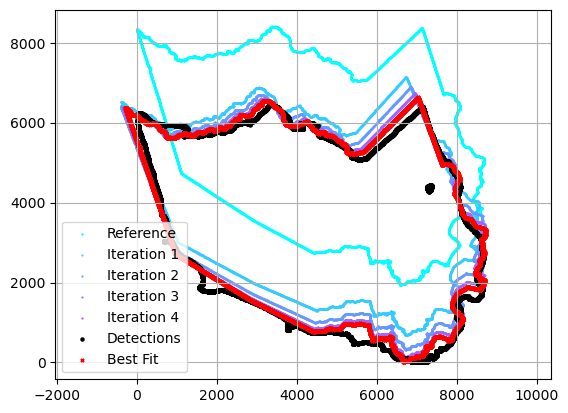

In [10]:
transform_dict = performICPonIndex(boundaries, dnn_outputs, debug=False, plot=True, rotation=True, shear=False, perspective=False, icp_iterations=5, plot_every=1)

In [ ]:
initial_points

NameError: name 'initial_points' is not defined

In [ ]:
len(gen_dict.keys())

171